In [52]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


mypath = './Datasets/wisabi'
files = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f)) and "transactions.csv" in f]
files

['./Datasets/wisabi/enugu_transactions.csv',
 './Datasets/wisabi/fct_transactions.csv',
 './Datasets/wisabi/kano_transactions.csv',
 './Datasets/wisabi/lagos_transactions.csv',
 './Datasets/wisabi/rivers_transactions.csv']

In [51]:
dfs = list(map(pd.read_csv, files))
def transactions_to_cash_ts(df):
    for c in ['TransactionStartDateTime','TransactionEndDateTime']:
        df[c] = pd.to_datetime(df[c])
    df = df.drop(columns=['CardholderID',	'LocationID'])
    df= df[df.TransactionTypeID.isin([1,2])]#.drop(columns='TransactionTypeID')
    df['date'] = df.TransactionStartDateTime.dt.date
    df.drop(columns=['TransactionStartDateTime','TransactionEndDateTime'], inplace=True)
    df.loc[df.TransactionTypeID==2, 'TransactionAmount']*=(-1)
    df = df.drop(columns='TransactionTypeID')
    ts = df.groupby('date').sum().TransactionAmount
    return ts

tss = list(map(transactions_to_cash_ts,dfs))


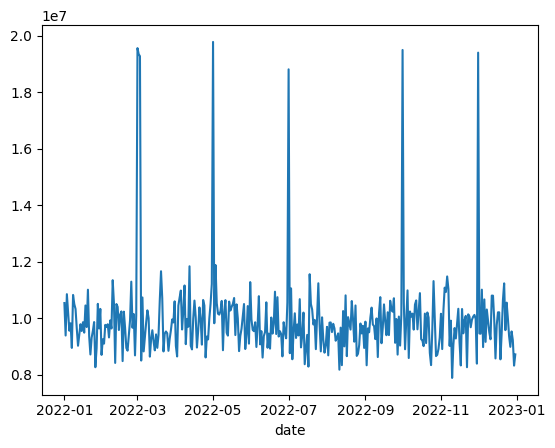

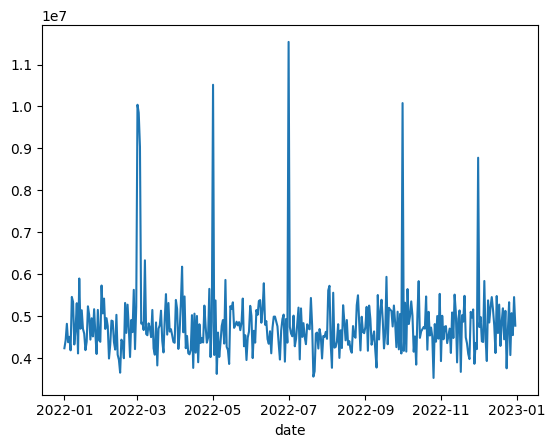

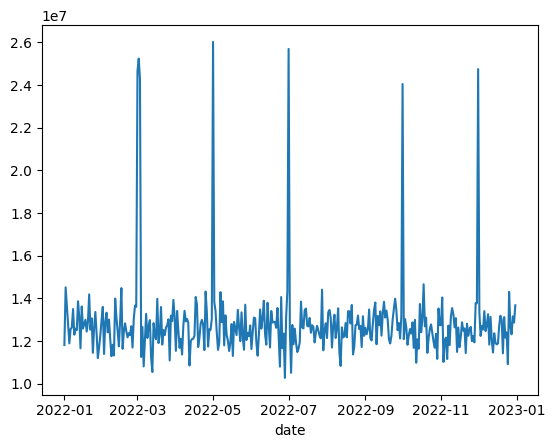

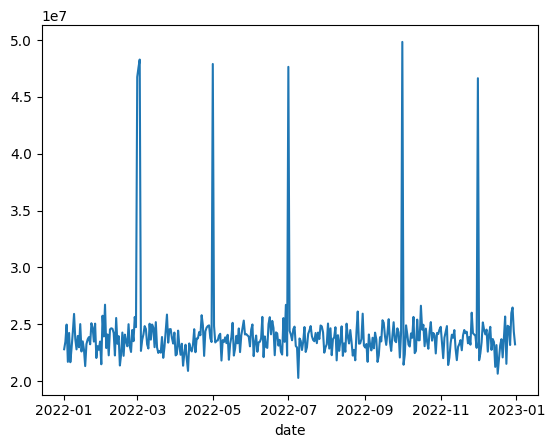

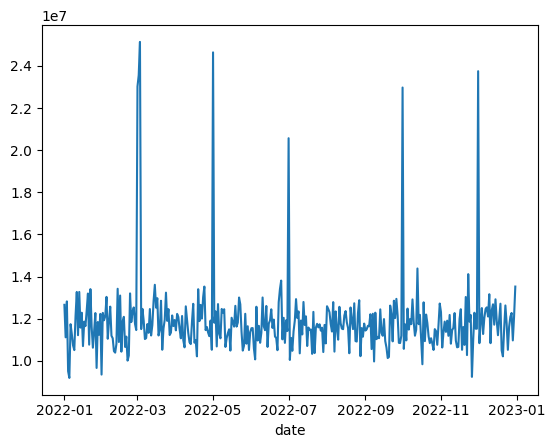

In [53]:
for ts in tss:
    ts.plot()
    plt.show()

In [50]:
df = pd.read_csv(files[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350251 entries, 0 to 350250
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   TransactionID             350251 non-null  object
 1   TransactionStartDateTime  350251 non-null  object
 2   TransactionEndDateTime    350251 non-null  object
 3   CardholderID              350251 non-null  object
 4   LocationID                350251 non-null  object
 5   TransactionTypeID         350251 non-null  int64 
 6   TransactionAmount         350251 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 18.7+ MB


<AxesSubplot: xlabel='date'>

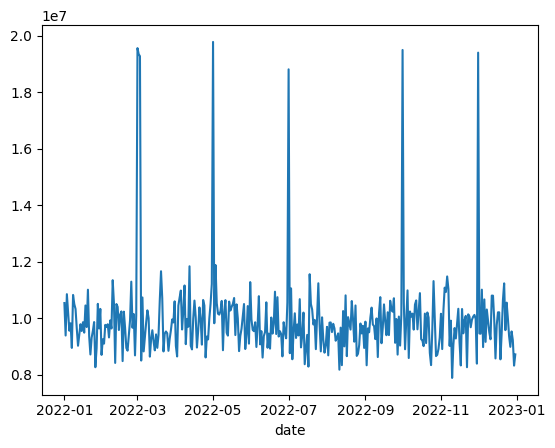

In [46]:
ts.plot()

<AxesSubplot: >

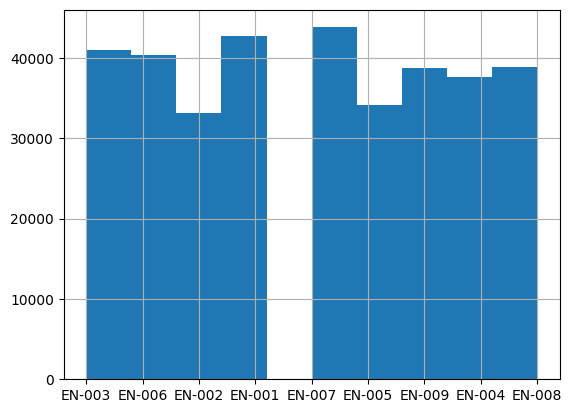

In [ ]:
df.LocationID.hist()

In [ ]:
df.TransactionStartDateTime.dt.date.nunique()

365

In [ ]:
import datetime


df['TransactionStartDateTime'].head(2)

0    1/1/2022 7:01
1    1/1/2022 7:02
Name: TransactionStartDateTime, dtype: object

In [ ]:
df['TransactionStartDateTime'].dt.date

AttributeError: Can only use .dt accessor with datetimelike values